# 9 Support Vector Machines

## 9.6 实验: 支持向量机

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import sample
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

### 9.6.1 支持向量分类器

cost参数用来设置观测穿过间隔的成本。如果cost参数值设置较小，那么间隔就会很宽，许多支持向量会落在间隔上或者穿过间隔。如果cost参数设置较大，那么间隔就会很窄，更少的支持向量会落在间隔上或者穿过间隔。

接下来使用svm.SVC()函数来拟合给定cost参数值的支持向量分类器。这里展示的是这个函数在二维数据上的应用，并依次画出决策边界。

首先生成属于两个不同类别的观测。

In [12]:
np.random.seed(1)
x = np.random.randn(20,2)
y = [-1]*10 + [1]*10
x[10:20,0:2] = x[10:20,0:2] + 1 

检查不同类别是否线性可分的。

In [10]:
# 绘制样本分布
def plot_data(X, y, type_list):
    plt.figure(figsize=(6, 5))
    pos = np.where(y == type_list[0]) # to find y=1
    neg = np.where(y == type_list[1]) # to find y=-1
    p1, = plt.plot(np.ravel(X[pos, 0]), np.ravel(X[pos, 1]), 'o', color = 'lightpink', markersize=8)
    p2, = plt.plot(np.ravel(X[neg, 0]), np.ravel(X[neg, 1]), 'o', color = 'lightblue', markersize=8)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend([p1, p2], ["y=="+str(type_list[0]), "y=="+str(type_list[1])])
    return plt

# 绘制决策边界
def plot_decisionBoundary(X, y, model, type_list, class_='linear'):
    plt = plot_data(X, y, type_list)
  
    # 线性 
    if class_ == 'linear':
        w = model.coef_
        b = model.intercept_
        xp = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
        yp = -(w[0, 0] * xp + b) / w[0, 1]
        plt.plot(xp, yp, 'k-', linewidth=2.0) # 决策边界
        plt.plot(model.support_vectors_[:,0], model.support_vectors_[:,1], 'kx', markersize=8) # 支持向量
    else: # 非线性
        x_1 = np.transpose(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100).reshape(1, -1))
        x_2 = np.transpose(np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100).reshape(1, -1))
        X1, X2 = np.meshgrid(x_1, x_2)
        vals = np.zeros(X1.shape)
        for i in range(X1.shape[1]):
            this_X = np.hstack((X1[:, i].reshape(-1, 1), X2[:, i].reshape(-1, 1)))
            vals[:, i] = model.predict(this_X)
        plt.contour(X1, X2, vals,1,colors='k')
        plt.show()

<module 'matplotlib.pyplot' from 'E:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

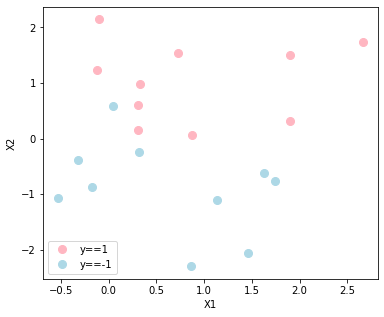

In [13]:
plot_data(x, np.ravel(y), [1,-1])

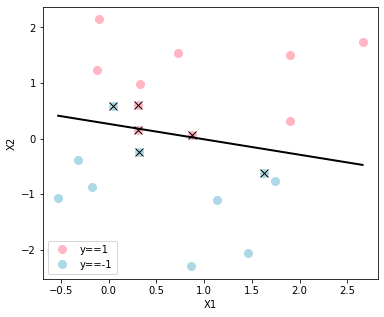

In [14]:
model = svm.SVC(C=10, kernel='linear').fit(x, y) # 线性核
plot_decisionBoundary(x, np.ravel(y), model, type_list = [1,-1])

In [15]:
print('support vectors:', model.support_)
print('numbers of support vectors:', model.n_support_)

support vectors: [ 0  4  9 13 15 16]
numbers of support vectors: [3 3]


如果使用一个更小的cost参数的值会怎么样呢？

support vectors: [ 0  3  4  6  7  8  9 11 12 13 14 15 16 17 18]
numbers of support vectors: [7 8]


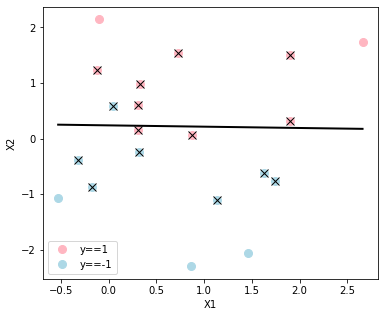

In [16]:
model = svm.SVC(C=0.1, kernel='linear').fit(x, y) 
plot_decisionBoundary(x, np.ravel(y), model, type_list = [1,-1])

print('support vectors:', model.support_)
print('numbers of support vectors:', model.n_support_)

接下来我们使用交叉验证在 cost 参数取不同值的情况下，比较线性核函数的 SVM 的表现，寻找最优参数 cost。

In [31]:
cost_params = [0.001 , 0.01 , 0.1, 1 ,5 ,10 ,100]
Detailed_results = pd.DataFrame(columns = ['cost', 'error'])
i = 0
for cost in cost_params:
    model = svm.SVC(C=cost, kernel='linear')
    Detailed_results.loc[i]=[cost, -cross_val_score(model,x,y,cv = 10,scoring = 'neg_mean_squared_error').mean()]
    i += 1

Detailed_results

,cost,error
0,0.001,0.2
1,0.010,0.2
2,0.100,0.6
3,1.000,0.4
4,5.000,0.4
5,10.000,0.4
6,100.000,0.4


In [32]:
best_params = Detailed_results[['cost']][Detailed_results['error']==Detailed_results['error'].min()].values[0]
best_model = svm.SVC(C=best_params, kernel='linear', probability=True).fit(x, y)
best_params

array([0.001])

接下来我们用 cost = 0.001来进行预测。首先生成一个测试集。

In [37]:
xtest = np.random.randn(20,2)
ytest = []
ytest = [np.random.choice([-1,1]) for i in range(20)]
index = [i==1 for i in ytest]
xtest[index,:] = xtest[index,:]+1

然后预测这些测试观测的类别标签。为了做出预测，通常使用通过交叉验证获得的最好的模型。

In [38]:
yhat = best_model.predict(xtest)
pd.DataFrame(confusion_matrix(ytest, yhat), index = ['truth -1','truth 1'], columns = ['predict -1','predict 1'])

,predict -1,predict 1
truth -1,3,4
truth 1,0,13


In [40]:
worst_params = Detailed_results[['cost']][Detailed_results['error']==Detailed_results['error'].max()].values[0]
worst_model = svm.SVC(C=worst_params, kernel='linear').fit(x, y)
yhat = worst_model.predict(xtest)
pd.DataFrame(confusion_matrix(ytest, yhat), index = ['truth -1','truth 1'], columns = ['predict -1','predict 1'])

,predict -1,predict 1
truth -1,4,3
truth 1,3,10


对模拟数据进行进一步的分割，使得它们是线性可分的

<module 'matplotlib.pyplot' from 'E:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

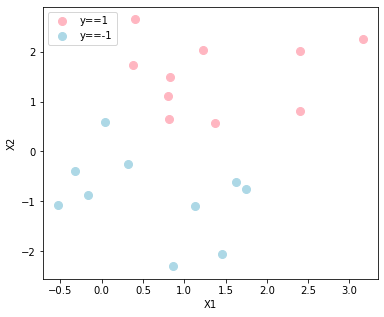

In [41]:
index = [i==1 for i in y]
x[index,:] = x[index,:] + 0.5
plot_data(x,np.ravel(y),[1,-1])

现在观测几乎是线性可分的了。拟合支持向量分类器并且画出得到的超平面，使用了更大的cost值，结果没有观测被误分。

support vectors: [ 0  9 16]
numbers of support vectors: [2 1]


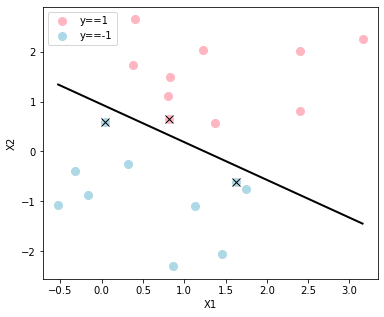

In [42]:
model = svm.SVC(C=100000, kernel='linear').fit(x, y)
plot_decisionBoundary(x, np.ravel(y), model, type_list = [1,-1])

print('support vectors:', model.support_) # 支持向量的索引
print('numbers of support vectors:', model.n_support_) # 每一类各有多少个支持变量

训练集没有出现分类错误，而且只使用了三个支持向量。但是从图中可以看出，间隔很窄。这个模型在测试数据上的表现似乎会很差。现在尝试使用更小的cost 值：

support vectors: [ 0  3  9 13 15 16]
numbers of support vectors: [3 3]


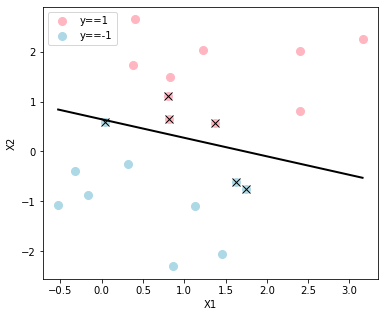

In [43]:
model = svm.SVC(C=1, kernel='linear').fit(x, y)
plot_decisionBoundary(x, np.ravel(y), model, type_list = [1,-1])

print('support vectors:', model.support_)
print('numbers of support vectors:', model.n_support_)

cost=1 时间隔更宽，并且使用了六个支持向量。在测试数据上，这个模型的表现比 cost=100000 的模型更好。

### 9.6.2 支持向量机

现在对 kernel 参数取不同的值。使用 kernel = "poly" 拟合多项式核函数的SVM ，使用 kernel= "rbf" 拟合径向基核函数的SVM。

![](fig/8.png)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

首先生成一些具有非线性类别边界的数据，如下：

<module 'matplotlib.pyplot' from 'E:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

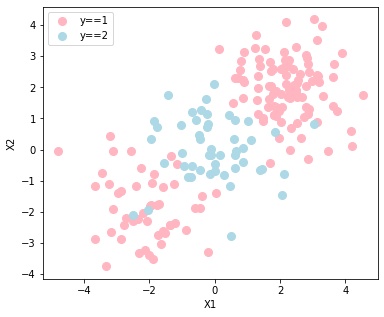

In [46]:
np.random.seed(1)
x = np.random.randn(200,2)
x[0:100,:] = x[0:100,:] + 2
x[100:150,:] = x[100:150,:] - 2
y = [1]*150 + [2]*50
plot_data(x,np.ravel(y),[1,2])

数据被随机地分成训练集和测试集。然后使用svm.SVC()函数拟合训练数据，其中核函数取径向核函数，且 γ = 1 ：

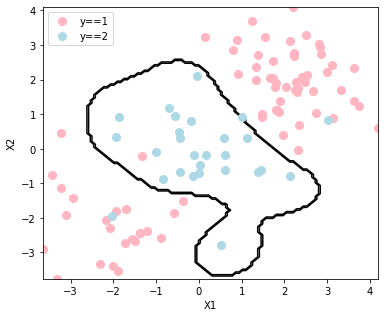

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

model = svm.SVC(C=1, kernel='rbf', gamma = 1).fit(X_train, y_train)
plot_decisionBoundary(X_train, np.ravel(y_train), model, type_list = [1,2], class_='rbf')

结果显示， SVM 有个明显非线性的决策边界。

从图中可以看出，使用这个SVM 进行预测，有相当一部分训练观测都被误分了。如果增大 cost 的值，就可减少训练数据的误差。但是，这样做的代价是得到一个更加不规则的决策边界，而这会产生过拟合数据的风险。

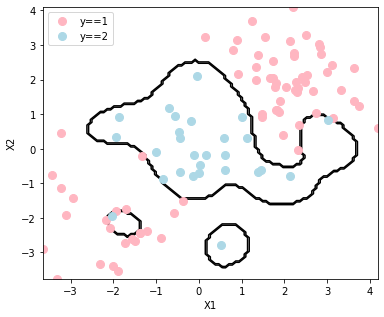

In [48]:
model = svm.SVC(C=10000, kernel='rbf', gamma = 1).fit(X_train, y_train)
plot_decisionBoundary(X_train, np.ravel(y_train), model, type_list = [1,2], class_='rbf')

所以我们考虑使用交叉验证来选择径向核函数最优的 γ 值以及 cost 的值。

In [49]:
cost_params = [0.1, 1 ,10 ,100 ,1000]
gamma_params = [0.5, 1 ,2 ,3 ,4]

Detailed_results = pd.DataFrame(columns = ['cost', 'gamma', 'error'])
i = 0
for cost in cost_params:
    for gm in gamma_params:
        model = svm.SVC(C=cost, kernel='rbf', gamma = gm)
        Detailed_results.loc[i]=[cost, gm, -cross_val_score(model,X_train, y_train,cv = 10,scoring = 'neg_mean_squared_error').mean()]
        i += 1
Detailed_results

,cost,gamma,error
0,0.1,0.5,0.18
1,0.1,1.0,0.27
2,0.1,2.0,0.27
3,0.1,3.0,0.27
4,0.1,4.0,0.27
5,1.0,0.5,0.07
6,1.0,1.0,0.07
7,1.0,2.0,0.09
8,1.0,3.0,0.10
9,1.0,4.0,0.10


In [50]:
best_params = Detailed_results[['cost', 'gamma']][Detailed_results['error']==Detailed_results['error'].min()].values[0]
best_params

array([1., 1.])

In [51]:
best_model = svm.SVC(C=best_params[0], kernel='rbf', gamma = best_params[1], probability=True).fit(X_train, y_train)
accuracy_score(y_test, best_model.predict(X_test))

0.95

In [53]:
yhat = best_model.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, yhat), index = ['truth -1','truth 1'], columns = ['predict -1','predict 1'])

,predict -1,predict 1
truth -1,74,3
truth 1,2,21


### 9.6.3 ROC 曲线

In [11]:
def plot_roc_curve(model, X, y):
    test_predict_label = model.decision_function(X_train)
    
    # 计算ROC
    fpr,tpr,threshold = roc_curve(np.array(y), model.predict_proba(X)[:,1], pos_label=2)# False Positive Rate, True Positive Rate
    roc_auc = auc(fpr,tpr) # 计算 auc

    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) # x:False Positive Rate，y:True Positive Rate
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 432x288 with 0 Axes>

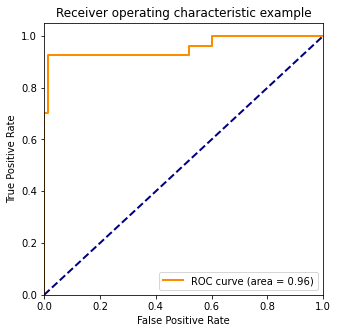

In [12]:
plot_roc_curve(best_model, X_train, y_train)

SVM似乎能给出精确的预测。但是增加 γ 可以更加光滑地拟合数据，并且进一步提高预测的准确度。

<Figure size 432x288 with 0 Axes>

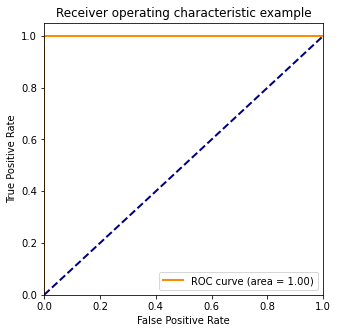

In [13]:
another_model = svm.SVC(C=best_params[0], kernel='rbf', gamma = 50, probability=True).fit(X_train, y_train)

plot_roc_curve(another_model, X_train, y_train)

然而这些都是训练数据的ROC曲线。通常我们更关注测试数据的预测的精度。

<Figure size 432x288 with 0 Axes>

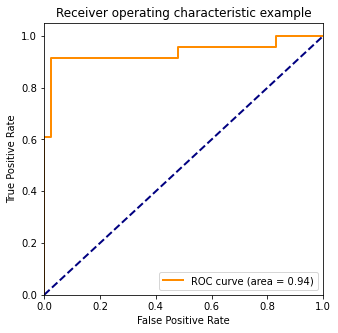

In [14]:
plot_roc_curve(best_model, X_test, y_test)

<Figure size 432x288 with 0 Axes>

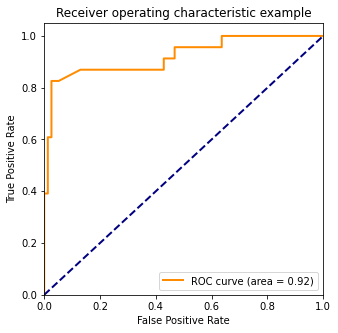

In [15]:
plot_roc_curve(another_model, X_test, y_test)

### 9.6.4 多分类的 SVM

首先生成第三类观测：

In [16]:
x = np.random.randn(250,2)
cut = sample(range(0,250), 2)
y = [0] * min(cut) + [1] * (max(cut) - min(cut)) + [2] * (250 - max(cut))
index = [i==0 | i==2  for i in y]
x[index,:] = x[index,:]+2

<module 'matplotlib.pyplot' from 'E:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

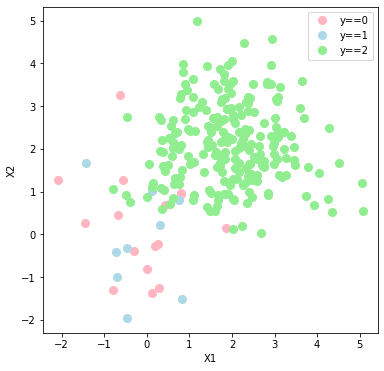

In [17]:
def plot_data1(X, y, type_list):
    plt.figure(figsize=(6, 6))
    pos = np.where(y == type_list[0])
    neg = np.where(y == type_list[1])
    mid = np.where(y == type_list[2])
    p1, = plt.plot(np.ravel(X[pos, 0]), np.ravel(X[pos, 1]), 'o', color = 'lightpink', markersize=8)
    p2, = plt.plot(np.ravel(X[neg, 0]), np.ravel(X[neg, 1]), 'o', color = 'lightblue', markersize=8)
    p3, = plt.plot(np.ravel(X[mid, 0]), np.ravel(X[mid, 1]), 'o', color = 'lightgreen', markersize=8)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend([p1, p2, p3], ["y=="+str(type_list[0]), "y=="+str(type_list[1]), "y=="+str(type_list[2])])
    return plt
plot_data1(x, np.ravel(y), [0,1,2])

In [18]:
model = OneVsRestClassifier(svm.SVC(C=10, kernel='rbf', gamma = 1,probability=True))
clt = model.fit(x,y)
yhat = clt.predict(x)

pd.DataFrame(confusion_matrix(y, yhat), index = ['truth 0','truth 1','truth 2'], columns = ['predict 0','predict 1','predict 2'])

,predict 0,predict 1,predict 2
truth 0,10,1,5
truth 1,1,6,2
truth 2,0,0,225


### 9.6.5 基因表达数据的应用

以下分析都使用 Khan 数据集，这个数据集由许多组织样本构成，这些样本对应四种不同的蓝色小圆细胞肿瘤。对于每个组织样本，基因表达测定都是在可用的。数据集由训练数据 xtrain 和 ytrain，以及测试数据 xtest 和 ytest 组成。

首先看数据的维数：

In [31]:
Khan_xtrain = pd.read_csv("Khan_xtrain.csv", index_col = 0)
Khan_ytrain = pd.read_csv("Khan_ytrain.csv", index_col = 0)
Khan_xtest = pd.read_csv("Khan_xtest.csv", index_col = 0)
Khan_ytest = pd.read_csv("Khan_ytest.csv", index_col = 0)

print('shape of Khan_xtrain:', np.shape(Khan_xtrain))
print('shape of Khan_xtrain:', np.shape(Khan_xtest))
print('length of Khan_xtrain:', len(Khan_ytrain))
print('length of Khan_ytest:', len(Khan_ytest))

shape of Khan_xtrain: (63, 2308)
shape of Khan_xtrain: (20, 2308)
length of Khan_xtrain: 63
length of Khan_ytest: 20


In [32]:
print(Khan_ytrain['x'].value_counts().sort_index())
print(Khan_ytest['x'].value_counts().sort_index())

1     8
2    23
3    12
4    20
Name: x, dtype: int64
1    3
2    6
3    6
4    5
Name: x, dtype: int64


以下是吴恩达给出的 SVM 与 LR 的选择技巧：

·	如果相对于样本量 m，特征变量个数 n 很大，选择逻辑回归或者线性核函数的 SVM；

·	如果特征变量个数 n 很少，样本量 m 中等，使用高斯核的 SVM；

·	如果特征变量个数 n 很少，样本量很大，增加更多的特征，然后选择逻辑回归或者线性核函数的 SVM。

In [33]:
model = svm.SVC(C = 10, kernel='linear').fit(Khan_xtrain, np.ravel(Khan_ytrain))

yhat = model.predict(Khan_xtrain)
Khan_ytrain = Khan_ytrain.reset_index(drop = True)
pd.DataFrame(confusion_matrix(Khan_ytrain, yhat), index = ['truth 1','truth 2', 'truth 3', 'truth 4'], columns = ['predict 1','predict 2','predict 3','predict 4'])

,predict 1,predict 2,predict 3,predict 4
truth 1,8,0,0,0
truth 2,0,23,0,0
truth 3,0,0,12,0
truth 4,0,0,0,20


我们更关注的是支持向量分类器在测试观测上的效果。

In [34]:
yhat = model.predict(Khan_xtest)
Khan_ytest = Khan_ytest.reset_index(drop = True)

pd.DataFrame(confusion_matrix(Khan_ytest, yhat), index = ['truth 1','truth 2', 'truth 3', 'truth 4'], columns = ['predict 1','predict 2','predict 3','predict 4'])    

,predict 1,predict 2,predict 3,predict 4
truth 1,3,0,0,0
truth 2,0,6,0,0
truth 3,0,2,4,0
truth 4,0,0,0,5
